## Looped RGB ANALYSIS
This notebook is for comparison of the RGB channels for experimental and simulated images to see if the watershed algorithm performs any better in creating annotations of comet outlines.

In [5]:
import numpy as np
#
def rgba2rgb(rgba, background = (255, 255, 255)):
    '''
    Function to convert RGBA images into RGB format. Input RGBA image (and background); output RGB image.
    '''
    rows, cols, chans = rgba.shape
    #
    debug = False
    #
    if debug:
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
            return rgba
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 4, 'RGBA image must have 4 channels.'
    #
    rgb = np.zeros((rows, cols, 3), dtype = 'float32')
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
    #
    a = np.asarray(a, dtype='float32')/255.0
    #
    R, G, B = background
    #
    rgb[:, :, 0] = r*a + (1.0 - a)*R
    rgb[:, :, 1] = g*a + (1.0 - a)*G
    rgb[:, :, 2] = b*a + (1.0 - a)*B
    #
    return np.asarray(rgb, dtype = np.uint8)
#
def rgb2grey(rgb, negative = 0):
    '''
    Convert RGB image to greyscale. Input RGB (and flag indicating negative required), output greyscale image.
    '''
    rows, cols, chans = rgb.shape
    #
    debug = False
    #
    if debug:
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
        elif chans == 1:
            print("Greyscale image")
            return rgb
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 3, 'RGB image must have 3 channels.'
    #
    grey = np.zeros((rows, cols), dtype = 'float32')
    #
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    #
    grey[:, :] = (0.2125*(r*negative + (negative - 1.0)*r) + 
                  0.7154*(g*negative + (negative - 1.0)*g) + 
                  0.0721*(b*negative + (negative - 1.0)*b))
    #
    return np.asarray(grey, dtype = np.uint8)
#
def ceilDiv(a, b):

    '''
    Return a//b rounded up.
    '''
    ceiling = -(-a//b)
    return ceiling

def rgbSeperate(rgb, filename, withPlots = True):
    '''
    Seperate RGB image into the R, G, B components and plot image in each of these individual channels.
    '''
    rows, cols, chans = rgb.shape
    #
    debug = False
    #
    if debug:
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
        elif chans == 1:
            print("Greyscale image")
            return rgb
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 3, 'RGB image must have 3 channels.'
    #
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    rMax = np.max(r)
    gMax = np.max(g)
    bMax = np.max(b)
    print("max pixel intensities for the red, green and blue channels are: ", rMax, gMax, bMax)
    #
    if withPlots == True:
        plt.figure(figsize = (12, 9))
        plt.subplot(2, 2, 1)
        plt.title("raw image" + str(filename))
        plt.imshow(rgb, cmap='afmhot')
        plt.subplot(2, 2, 2)
        plt.title("red channel")
        plt.imshow(r, cmap='afmhot')
        plt.subplot(2, 2, 3)
        plt.title("green channel")
        plt.imshow(g, cmap='afmhot')
        plt.subplot(2, 2, 4)
        plt.title("blue channel")
        plt.imshow(b, cmap='afmhot')
        plt.show()
        #
        nBins = 256
        plt.figure(figsize = (12, 9))
        plt.subplot(4, 1, 1)
        plt.hist(imgRGB.flatten(), bins = nBins, color = 'k')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 2)
        plt.hist(r.flatten(), bins = nBins, color = 'r')
        plt.yscale("log")
        plt.xlim(-1, 256)
        #
        plt.subplot(4, 1, 3)
        plt.hist(g.flatten(), bins = nBins, color = 'g')
        plt.yscale("log")
        plt.xlim(-1, 256)
        #
        plt.subplot(4, 1, 4)
        plt.hist(b.flatten(), bins = nBins, color = 'b')
        plt.yscale("log")
        plt.xlim(-1, 256)
        #

    return r, g, b

## Process image to get RGB and grey versions and plot with intensity spectrums

In [2]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
import glob
import os
import sys
import numpy as np
import scipy.ndimage as scimg
import matplotlib.pyplot as plt
%matplotlib inlinesgsdhins
'li'# 
#################################################
# Read in bmp files in directory
#
#real_test_dir = '../../datasets/comet/test/*.bmp'  #where the test directory is comapred to this notebook location
image_dir = 'CometImages/CA210609/Collated/4GyB/bmp/*.bmp'  #where the image directory is - find all bmp files here
fileList= sorted(glob.glob(image_dir))  #whole file path, as set in above line
#print("Files read in (whole path) are", fileList)
#
fileNames = [os.path.basename(x) for x in sorted(glob.glob(image_dir))]  #only file name with extension
print("\nFile names (with extension) are:", fileNames)
#
nFiles = len(fileNames)
print("\n",nFiles, " files will be analysed")
#
fileNamesSplit = np.empty((nFiles), dtype = 'object')
for n in range (0, nFiles):
    x = fileNames[n]
    fileNamesSplit[n] = os.path.splitext(x)[0]   #remove extension from file name
##
fileNameArray = np.empty((nFiles), dtype = 'object') #initialise empty 2d array to fill with strings for file name and type
for n in range (0, nFiles):
    fileNameArray[n] = fileNamesSplit[n]
print("\nfileNameArray is: ", fileNameArray)   #without extension
#
all_comets = {}
noComets = ['files not producing any annotations']

#Whether or not we want to write to JSON file
write = False
savePlots = False   #whether we want to save annotated images 
reduced_annotations = False

#by what factor to reduce comet annotations
reduction = 20

#files and directories to be written to
out_file_name = 'JSON/RGB-train-thr10exp5.json'
#out_file_name = 'JSON/RGB-exp-val' +str(reduction)+ '.json'
if write == True:
    print("\noutput json file is: ", out_file_name) 
else:
    print("\nnot writing annoations to JSON file")

    #save_dir_plots = 'RGB-exp-val' + str(reduction)+ '/'
save_dir_plots = 'annotated-images/RGB-train-thr10-exp5/' 
if savePlots == True: 
    print("\ndirectory plots saved in is: ", save_dir_plots)
else: 
    print("\nnot saving annotation plots to file")

#########################################


Date and time  2021-06-24 10:46:22.372275

File names (with extension) are: ['4GyB000.bmp', '4GyB001.bmp', '4GyB0010.bmp', '4GyB0011.bmp', '4GyB0012.bmp', '4GyB0013.bmp', '4GyB0014.bmp', '4GyB0015.bmp', '4GyB0016.bmp', '4GyB0017.bmp', '4GyB0018.bmp', '4GyB0019.bmp', '4GyB002.bmp', '4GyB0020.bmp', '4GyB0021.bmp', '4GyB0022.bmp', '4GyB0023.bmp', '4GyB0024.bmp', '4GyB0025.bmp', '4GyB0026.bmp', '4GyB0027.bmp', '4GyB0028.bmp', '4GyB0029.bmp', '4GyB003.bmp', '4GyB004.bmp', '4GyB005.bmp', '4GyB006.bmp', '4GyB007.bmp', '4GyB008.bmp', '4GyB009.bmp']

 30  files will be analysed

fileNameArray is:  ['4GyB000' '4GyB001' '4GyB0010' '4GyB0011' '4GyB0012' '4GyB0013'
 '4GyB0014' '4GyB0015' '4GyB0016' '4GyB0017' '4GyB0018' '4GyB0019'
 '4GyB002' '4GyB0020' '4GyB0021' '4GyB0022' '4GyB0023' '4GyB0024'
 '4GyB0025' '4GyB0026' '4GyB0027' '4GyB0028' '4GyB0029' '4GyB003'
 '4GyB004' '4GyB005' '4GyB006' '4GyB007' '4GyB008' '4GyB009']

not writing annoations to JSON file

not saving annotation plots to file


## Edge finding and cluster expansion

Algorithm used is to shift logical array `picture` containing thresholded image left, forming array `imgShift`. The array `not imgShift and picture` then contains the right edges in the original image. Shifts right, down and up allow the left, upper and lower edges to be found. "Corner" effects are taken care of by shifts in two doections (e.g. left and up). Taking the logical or of the results gives all edges.

In [3]:
def edgeFinderIn(picture, edgeWidth, useDiag = True):
    '''
    Return array containing pixels in edges (of width edgeWidth) of input (thresholded) image.
    The edges are inside the original image. The flag useDiag ensures "corner" pixels are selected.
    '''
    #
    shiftR = edgeWidth
    shiftC = edgeWidth
    nRows, nCols = picture.shape
    edges = np.full((nRows, nCols), False)
    imgShift = np.full((nRows, nCols), False)
    #
    # Right edge
    imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
    imgShift[0:nRows, nCols - shiftC:nCols] = False
    edges = np.logical_and(picture, np.logical_not(imgShift))
    #
    # Left edge 
    imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
    imgShift[0:nRows, 0:shiftC] = False
    edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    # Lower edge 
    imgShift[shiftR:nRows, 0:nCols] = picture[0:nRows - shiftR, 0:nCols]
    imgShift[0:shiftR, 0:nCols] = False    
    edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    # Upper edge 
    imgShift[0:nRows - shiftR, 0:nCols] = picture[shiftR:nRows, 0:nCols]    
    imgShift[nRows - shiftR:nRows, 0:nCols] = False
    edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    if useDiag:
        #
        # Left upper edge
        imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
        imgShift[0:nRows, nCols - shiftC:nCols] = False
        imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
        imgShift[0:shiftR, 0:nCols] = False    
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
        #
        # Left lower edge
        imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
        imgShift[0:nRows, nCols - shiftC:nCols] = False
        imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
        imgShift[nRows - shiftR:nRows, 0:nCols] = False
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
        #
        # Right upper edge 
        imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
        imgShift[0:nRows, 0:shiftC] = False
        imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
        imgShift[0:shiftR, 0:nCols] = False    
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
        #
        # Right lower edge 
        imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
        imgShift[0:nRows, 0:shiftC] = False
        imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
        imgShift[nRows - shiftR:nRows, 0:nCols] = False
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
        #
    return edges
#
#
def expander(picture, edgeWidth, useDiag = True):
    '''
    Return array containing thresholded regions expanded by band of width edgeWidth. The flag useDiag ensures
    "corner" pixels are included correctly.
    '''
    #
    shiftR = 1
    shiftC = 1
    nRows, nCols = picture.shape
    edges = np.full((nRows, nCols), False)
    edgeSum = np.full((nRows, nCols), False)
    imgShift = np.full((nRows, nCols), False)
    #
    for  nE in range(0, edgeWidth):
        #
        # Left edge
        imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
        imgShift[0:nRows, nCols - shiftC:nCols] = False
        edges = np.logical_and(np.logical_not(picture), imgShift)
        #
        # Right edge 
        imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
        imgShift[0:nRows, 0:shiftC] = False
        edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        # Upper edge 
        imgShift[shiftR:nRows, 0:nCols] = picture[0:nRows - shiftR, 0:nCols]
        imgShift[0:shiftR, 0:nCols] = False    
        edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        # Lower edge 
        imgShift[0:nRows - shiftR, 0:nCols] = picture[shiftR:nRows, 0:nCols]    
        imgShift[nRows - shiftR:nRows, 0:nCols] = False
        edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        if useDiag:
            #
            # Left upper edge
            imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
            imgShift[0:nRows, nCols - shiftC:nCols] = False
            imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
            imgShift[0:shiftR, 0:nCols] = False    
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
            #
            # Left lower edge
            imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
            imgShift[0:nRows, nCols - shiftC:nCols] = False
            imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
            imgShift[nRows - shiftR:nRows, 0:nCols] = False
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
            #
            # Right upper edge 
            imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
            imgShift[0:nRows, 0:shiftC] = False
            imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
            imgShift[0:shiftR, 0:nCols] = False    
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
            #
            # Right lower edge 
            imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
            imgShift[0:nRows, 0:shiftC] = False
            imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
            imgShift[nRows - shiftR:nRows, 0:nCols] = False
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        picture = np.logical_or(picture, edges)
        edgeSum = np.logical_or(edges, edgeSum)
    #
    return picture, edgeSum
#

## Looped processing of all images in directory read in at beginning

Date and time  2021-06-24 10:46:47.864446
Type of raw image file is uint8
Type of greyscale image file is uint8
Number of rows 2048 of columns 2048 of pixels 4194304 and depth 4
Maximum pixel intensity of raw image 255
Maximum pixel intensity of grey image 221
 
Number of thresholds 2
Number of rows in figure 3
 


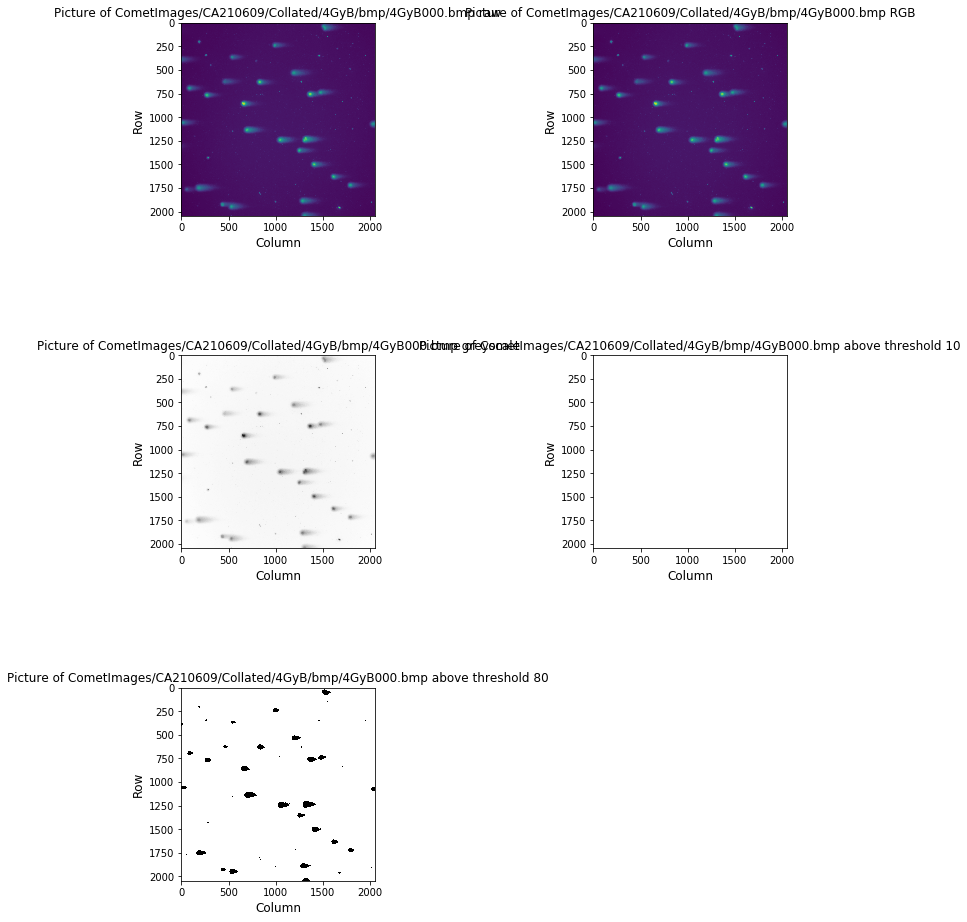

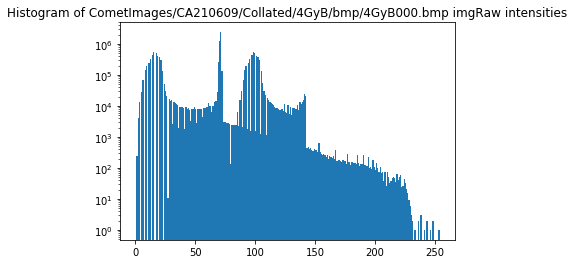

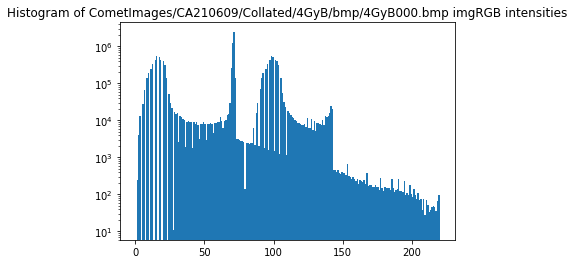

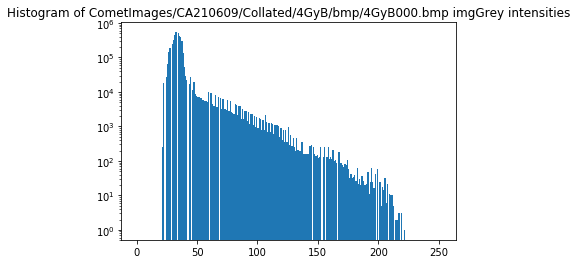

max pixel intensities for the red, green and blue channels are:  253 231 142


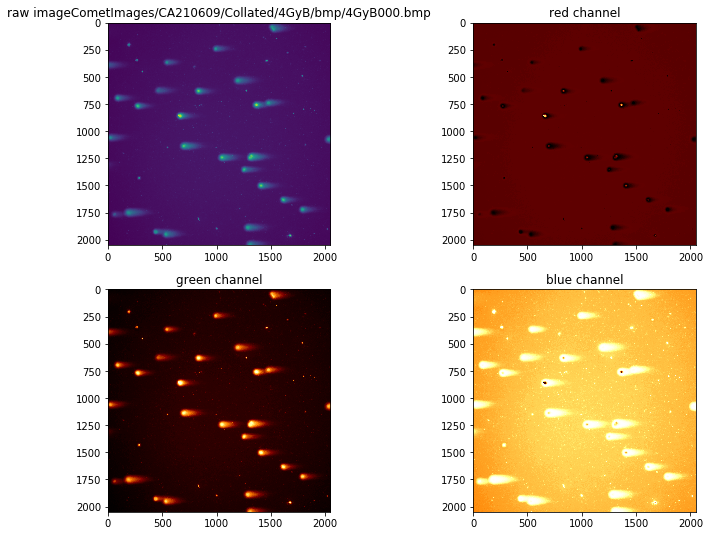

threshold used is:  [10, 80]


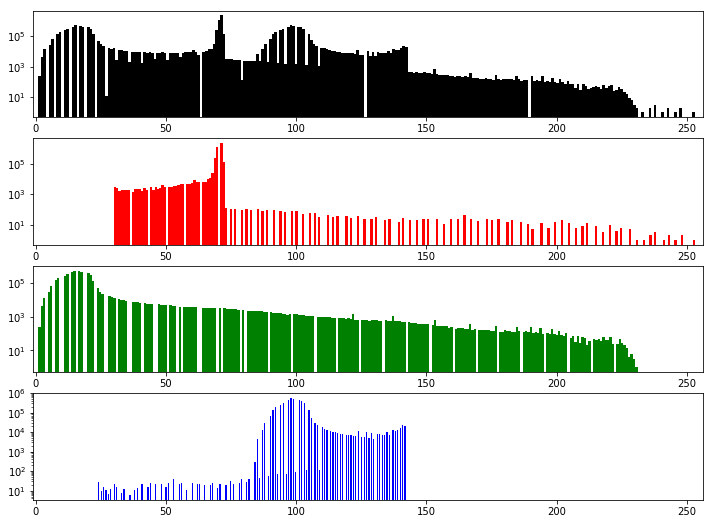

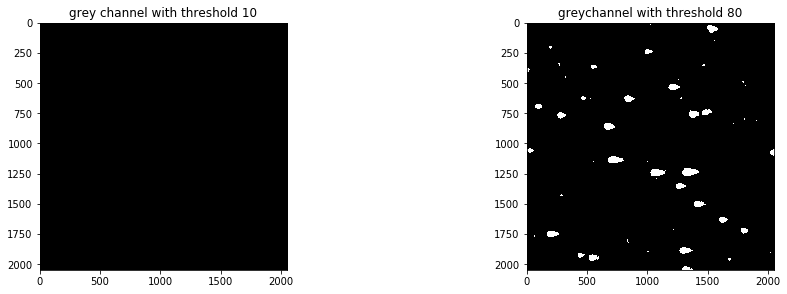

 
Cluster ID using Watershed algorithm
Cluster threshold 10, head threshold 80.
Min number of pixels in cluster 100, max number 20000.
Min number of pixels in head 50, max number 10000.
shape of colDotsClus is:  (2048, 2048)
 


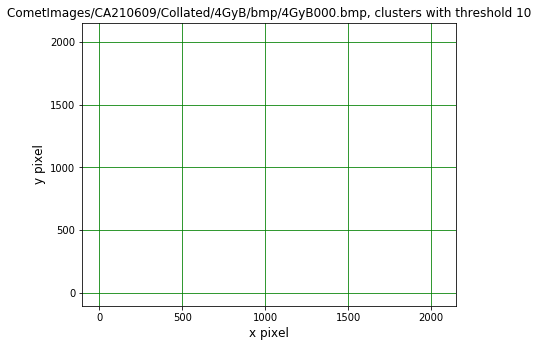

NameError: name 'nC' is not defined

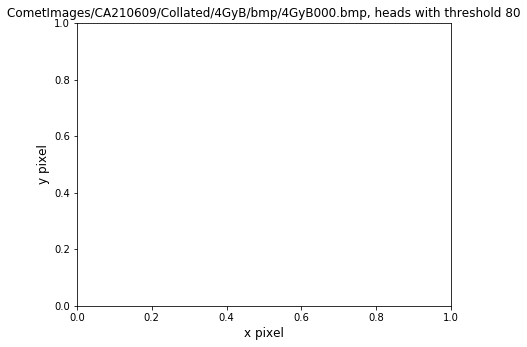

In [4]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
import sys
import numpy as np
import scipy.ndimage as scimg
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import os
import json
from jsonmerge import merge
# 
################################################################################

# BEGIN LOOP  for analysis of all images in directory
## Initial image processing
#Open image, convert to grey scale and apply a range of increasing thresholds.
#
for iFile in range(0,nFiles):
    # Read in image
    imFile = fileList[iFile]
    imgRaw = plt.imread(imFile)
    #imgRaw = imgRaw / np.amax(imgRaw)  
    #
    # Number of rows and columns. Depth is 3 for RGB, 4 for RGBA image. A is opacity (alpha)
    nRows = imgRaw.shape[0] 
    nCols = imgRaw.shape[1]
    nDepth = imgRaw.shape[2]
    #
    # Determine image format and process accordingly
    if nDepth == 4:
        imgRGB = rgba2rgb(imgRaw)
        imgGrey = rgb2grey(imgRGB, 1)
    elif nDepth == 3:
        imgRGB = imgRaw
        imgGrey = rgb2grey(imgRGB, 1)
    elif nDepth == 1:
        imgRGB = imgRaw
        imgGrey = imgRaw
    else:
        print(" ")
        print("Unexpected image depth",nDepth)
        sys.stop()
    #
    maxPixRaw = np.amax(imgRaw)
    maxPixGrey = np.amax(imgGrey)
    maxPixRGB = np.amax(imgRGB)
    # Set thresholds for applying to image (lowest to highest)
    #thresh = np.array([10, 180]) 
    #
    thresh = np.array([10, 80]) #was 30, 150
    nThresh = len(thresh)
    img = np.zeros((nRows, nCols))
    imgThr = np.zeros((nRows, nCols, nThresh))
    #
    print("Type of raw image file is",imgRaw.dtype)
    print("Type of greyscale image file is",imgGrey.dtype)
    print("Number of rows",nRows,"of columns",nCols,"of pixels",nRows*nCols,"and depth",nDepth)
    print("Maximum pixel intensity of raw image", maxPixRaw)
    print("Maximum pixel intensity of grey image", maxPixGrey)
    #
    # Plot image at various stages of processing
    nFigRows = 2 + ceilDiv(nThresh, 2)
    print(" ")
    print("Number of thresholds",nThresh)
    print("Number of rows in figure",nFigRows)
    for nT in range(0, nThresh):
        imgThr[:, :, nT] = imgGrey > thresh[nT]
    #
    print(" ")
    fig = plt.figure(figsize=(nFigRows*4, 14))
    fig.add_subplot(nFigRows, 2, 1)
    plt.title("Picture of " + imFile + " raw")
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    imgplot = plt.imshow(imgRaw, cmap = "jet")
    #
    fig.add_subplot(nFigRows, 2, 2)
    plt.title("Picture of " + imFile + " RGB")
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    imgplot = plt.imshow(imgRGB, cmap = "jet")
    #
    fig.add_subplot(nFigRows, 2, 3)
    plt.title("Picture of " + imFile + " greyscale")
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    imgplot = plt.imshow(imgGrey, cmap = "Greys")
    #
    for nT in range(0, nThresh):
        fig.add_subplot(nFigRows, 2, 4 + nT)
        plt.title("Picture of " + imFile + " above threshold " + str(thresh[nT]))
        plt.xlabel('Column', fontsize = 12)
        plt.ylabel('Row', fontsize = 12)
        imgplot = plt.imshow(imgThr[:, :, nT], cmap = "Greys")
    #
    plt.tight_layout()
    plt.show()
    #
    # plot intensities of image in states raw, RGB and grey

    fig, ax = plt.subplots(1)
    plt.title("Histogram of " + str(imFile) + " imgRaw intensities")
    n, bins, patches = ax.hist(imgRaw.flatten(), bins=np.arange(0, maxPixRaw, 1), log=True)
    plt.show()
    #
    fig, ax = plt.subplots(1)
    plt.title("Histogram of " + str(imFile) + " imgRGB intensities")
    n, bins, patches = ax.hist(imgRGB.flatten(), bins=np.arange(0, maxPixGrey, 1), log=True)
    plt.show()
    #
    fig, ax = plt.subplots(1)
    plt.title("Histogram of " + str(imFile) + " imgGrey intensities")
    n, bins, patches = ax.hist(imgGrey.flatten(), bins=np.arange(0, maxPixRGB, 1), log=True)
    plt.show()
    #
    ############# RGB Analysis
    R, G, B = rgbSeperate(imgRGB, imFile, withPlots = True)
    #
    #red variables
    rThresh = [50, 170]
    rLow = R > rThresh[0]   #low threshold for comets
    rHigh = R > rThresh[1]   #high threshold for heads
    #
    #green variables
    gThresh = [10, 90]
    gLow = G > gThresh[0]
    gHigh = G > gThresh[1]
    #
    #grey variables
    greyThresh = [10,80]  #20, 180 is what this was
    greyLow = imgGrey > greyThresh[0]
    greyHigh = imgGrey > greyThresh[1]
    #
    #DEFINE CHANNEL OF IMAGE TO ANALYSE
    channel = 'grey'
    #
    if channel == 'red':
        imgGrey = R
        thresh = rThresh
        thrLow = rLow
        thrHigh = rHigh
        print("")
        print("red channel analysis")
    elif channel == 'green':
        imgGrey = G
        thresh = gThresh
        thrLow = gLow
        thrHigh = gHigh
        print("")
        print("green channel analysis")
    elif channel == 'grey':
        imgGrey = imgGrey
        thresh= greyThresh
        thrLow = greyLow
        thrHigh = greyHigh
        print("threshold used is: ", thresh)
    else:
        print("undefined channel for analysis")
        sys.stop()
       

    #
    fig = plt.figure(figsize = (16,10))
    plt.subplot(2,2,1)
    plt.title(str(channel) + " channel with threshold " + str(thresh[0]))
    plt.imshow(thrLow, cmap='afmhot')
    plt.subplot(2,2,2)
    plt.title(str(channel) + "channel with threshold " + str(thresh[1]))
    plt.imshow(thrHigh, cmap='afmhot')
    plt.show()
    #
#####################################################################
## Identify clusters using watershed algorithm
#Identify "clusters" at the lowest threshold and "heads" at the higher threshold.
#
    debug = False
    if debug:
        print("Running in debug mode!")
        clusPic = np.zeros((nRows, nCols))
    #
    # Requirements on minimum and maximum number of pixels in wheels at the cluster and head thresholds
    minClusPixels = 100
    maxClusPixels = 20000 #nRows*nCols/10
    minHeadPixels = 50
    maxHeadPixels = 10000  #nRows*nCols/10
    #
    print(" ")
    print("Cluster ID using Watershed algorithm")
    print("Cluster threshold",thresh[0],"\b, head threshold",thresh[1],"\b.")
    print("Min number of pixels in cluster",minClusPixels,"\b, max number",maxClusPixels,"\b.")
    print("Min number of pixels in head",minHeadPixels,"\b, max number",maxHeadPixels,"\b.")
    #
    # Define grid of markers and background marker value:
    nStepCols = 2
    nStepRows = 2
    rMark, cMark = np.ogrid[0:nRows:nStepRows, 0:nCols:nStepCols]
    if debug:
        print(" ")
        print("rMark.shape",rMark.shape,"cMark.shape",cMark.shape)
    mStart = 1
    markers = np.zeros((nRows, nCols)).astype(np.int)
    markers[rMark, cMark] = rMark/nStepRows + cMark*nRows/(nStepRows*nStepCols) + mStart
    if debug:
        plt.figure(figsize = (6.7, 5.2))
        plt.imshow(markers, cmap = "CMRmap");
    #
    # Create image with cluster threshold and run watershed algorithm
    clusImg = imgGrey > thresh[0]
    if debug:
        plt.figure(figsize = (6.7, 5.2))
        plt.imshow(clusImg);
    colDotsClus = ndimage.watershed_ift(clusImg.astype(np.uint8), markers)
    print("shape of colDotsClus is: ", colDotsClus.shape)
    #
    # Remove "isolated" markers (i.e. markers in regions where no cluster found)
    colDotsClus[rMark, cMark] = colDotsClus[rMark + 1, cMark]
    #
    # Find the value of the marker of the last identified regions
    mMaxClus = np.amax(colDotsClus)
    #
    # Positions of marker values
    boolClus = colDotsClus >= mStart
    nFoundClus = len(np.unique(colDotsClus[boolClus]))
    rMarkerClus = np.zeros(nFoundClus)
    rMarkerClus = np.unique(colDotsClus[boolClus])
    #
    # Select the clusters, first pass (determine accepted number). Must exclude tiny clusters (noise) and any 
    # really large clusters (background regions in image).
    nClus = 0
    cMarkerClus = np.zeros(nFoundClus)
    maxInDotClus = 0
    for nR in range(0, nFoundClus):
        boolClus = colDotsClus == rMarkerClus[nR]
        nHereCl = np.sum(boolClus)
        if nHereCl < minClusPixels or nHereCl > maxClusPixels:
            continue
        maxInDotClus = max(maxInDotClus, nHereCl)
        cMarkerClus[nClus] = rMarkerClus[nR]
        nClus += 1
    #
    # Create image with head threshold and run watershed algorithm
    headImg = imgGrey > thresh[1]
    if debug:
        plt.figure(figsize = (6.7, 5.2))
        plt.imshow(headImg);
    colDotsHead = ndimage.watershed_ift(headImg.astype(np.uint8), markers)
    #
    # Remove "isolated" markers
    colDotsHead[rMark, cMark] = colDotsHead[rMark + 1, cMark]
    #
    # Find the value of the marker of the last identified regions.
    mMaxHead = np.amax(colDotsHead)
    #
    # Positions of marker values that are not background
    boolHead = colDotsHead > mStart
    nFoundHead = len(np.unique(colDotsHead[boolHead]))
    rMarkerHead = np.zeros(nFoundHead)
    rMarkerHead = np.unique(colDotsHead[boolHead])
    #
    # Select the heads, first pass (determine accepted number). Must exclude tiny clusters (noise) and any 
    # really large clusters (background regions in image).
    nHead = 0
    cMarkerHead = np.zeros(nFoundHead)
    maxInDotHead = 0
    for nR in range(0, nFoundHead):
        boolHead = colDotsHead == rMarkerHead[nR]
        nHereHd = np.sum(boolHead)
        if nHereHd < minHeadPixels or nHereHd > maxHeadPixels:
            continue
        maxInDotHead = max(maxInDotHead, nHereHd) 
        cMarkerHead[nHead] = rMarkerHead[nR]
        nHead += 1
    #
    # Colour table for plots
    nColTab = 4
    colorTab = ['r', 'orange', 'b', 'c']
    #
    # Information on clusters
    nInCluster = np.zeros(nClus).astype(int)
    iClusSum = np.zeros(nClus)
    #
    # Information on pixels in clusters
    lClus = np.sum(clusImg)
    #
    # Safe size of arrays would be number of pixels in image. Try to reduce size by using number of pixels in clusters
    # The factor lFact can be used to expand array sizes
    #lFact = 4
    lFact = 20
    indexCl = np.zeros(lFact*lClus)
    cPixelsCl = np.zeros(lFact*lClus).astype(int)
    rPixelsCl = np.zeros(lFact*lClus).astype(int)
    iPixelsCl = np.zeros(lFact*lClus)
    #
    # Information on head
    nInHead = np.zeros(nHead).astype(int)
    iHeadSum = np.zeros(nHead)
    #
    # Information on pixels in head (lHead must be large enough...here probably larger than usually needed)
    lHead = lClus
    lFact = 20
    indexHd = np.zeros(lFact*lHead)
    cPixelsHd = np.zeros(lFact*lHead).astype(int)
    rPixelsHd = np.zeros(lFact*lHead).astype(int)
    iPixelsHd = np.zeros(lFact*lHead)
    #
    # Temporary information 
    cPixelsHere = np.zeros(lClus).astype(int)
    rPixelsHere = np.zeros(lClus).astype(int)
    iPixelsHere = np.zeros(lClus)
    thisPic = np.zeros((nRows, nCols))
    #
    # Find pixels in clusters, determine positions and plot 
    fig = plt.figure(figsize=(6.7, 5.2))
    ax = fig.add_subplot(1, 1, 1)
    plt.title(imFile + ", clusters with threshold " + str(thresh[0]), fontsize = 12)
    plt.xlabel('x pixel', fontsize = 12)
    plt.ylabel('y pixel', fontsize = 12)
    #
    # Figure control
    xOffMax = 2
    yOffMax = 2
    mSize = 0.001
    #
    nCol = 0
    nLastCl = 0
    for nC in range(0, nClus):
        #
        # Clusters
        boolClus = colDotsClus == cMarkerClus[nC]
        nHereCl = np.sum(boolClus).astype(int)
        #
        nInCluster[nC] = nHereCl
        #
        # Indices of x and y pixels
        rPixelsHere, cPixelsHere = np.where(boolClus)
        thisPic.fill(0) 
        thisPic[rPixelsHere, cPixelsHere] = 1
        if debug:
            clusPic += thisPic
        #
        # Intensities in pixels
        iPixelsHere = imgGrey[rPixelsHere, cPixelsHere]
        iClusSum[nC] = np.sum(iPixelsHere)
        #
        indexCl[nLastCl:nLastCl + nHereCl] = nC*np.ones(nHereCl)
        cPixelsCl[nLastCl:nLastCl + nHereCl] = cPixelsHere[:]
        rPixelsCl[nLastCl:nLastCl + nHereCl] = rPixelsHere[:]
        iPixelsCl[nLastCl:nLastCl + nHereCl] = iPixelsHere[:]
        #
        plt.scatter(cPixelsHere, rPixelsHere, s = mSize, c = colorTab[nCol], marker = 'o')
        rLab = np.amax(rPixelsHere[0:nHereCl]) + yOffMax
        cLab = np.amax(cPixelsHere[0:nHereCl]) + xOffMax
        plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
        nCol = nCol + 1
        if nCol > nColTab - 1:
             nCol = 0
        #
        nLastCl = nLastCl + nHereCl
        #
    #
    plt.xlim(-0.05*nCols, 1.05*nCols)
    plt.ylim(-0.05*nRows, 1.05*nRows)
    plt.grid(color = 'g')
    print(" ")
    plt.show()
    #
    # Find pixels in head, determine positions and plot
    fig = plt.figure(figsize=(6.7, 5.2))
    ax = fig.add_subplot(1, 1, 1)
    plt.title(imFile + ", heads with threshold " + str(thresh[1]), fontsize = 12)
    plt.xlabel('x pixel', fontsize = 12)
    plt.ylabel('y pixel', fontsize = 12)
    #
    # Figure control
    xOffMin = 15.0
    yOffMin = 35.0
    mSize = 0.001
    #
    nCol = 0
    nLastHd = 0
    for nH in range(0, nHead):
        boolHead = colDotsHead == cMarkerHead[nH]
        nHereHd = np.sum(boolHead).astype(int)
        #
        nInHead[nH] = nHereHd
        #
        # Indices of x and y pixels
        rPixelsHere, cPixelsHere = np.where(boolHead)
        #
        # Intensities in pixels
        iPixelsHere = imgGrey[rPixelsHere, cPixelsHere]
        iHeadSum[nH] = np.sum(iPixelsHere)
        #
        indexHd[nLastHd:nLastHd + nHereHd] = nC*np.ones(nInHead[nH])
        cPixelsHd[nLastHd:nLastHd + nHereHd] = cPixelsHere[0:nHereHd]
        rPixelsHd[nLastHd:nLastHd + nHereHd] = rPixelsHere[0:nHereHd]
        iPixelsHd[nLastHd:nLastHd + nHereHd] = iPixelsHere[0:nHereHd]
        #
        plt.scatter(cPixelsHere, rPixelsHere, s = mSize, c = colorTab[nCol], marker = 'o')
        rLab = np.amin(rPixelsHere) - xOffMin
        cLab = np.amin(cPixelsHere) - yOffMin
        plt.text(cLab, rLab, str(nH), color = colorTab[nCol])
        nCol = nCol + 1
        if nCol > nColTab - 1:
             nCol = 0
        #
        nLastHd = nLastHd + nHereHd
    #
    plt.xlim(-0.05*nCols, 1.05*nCols)
    plt.ylim(-0.05*nRows, 1.05*nRows)
    plt.grid(color = 'g')
    print(" ")
    plt.show()
###########################################################################    
## Make plots using stored cluster and head data
    #
    fig = plt.figure(figsize=(6.7, 5.2))
    ax = fig.add_subplot(1, 1, 1)
    plt.title(imFile + ", cluster and head edges", fontsize = 12)
    plt.xlabel('x pixel', fontsize = 12)
    plt.ylabel('y pixel', fontsize = 12)
    #
    nCol = 0
    #
    nLastCl = 0
    nLastClEd = 0
    for nC in range(0, nClus):
        #
        # Clusters
        nHereCl = nInCluster[nC]
        plt.scatter(cPixelsCl[nLastCl:nLastCl + nHereCl], rPixelsCl[nLastCl:nLastCl + nHereCl], 
                    s = mSize, c = colorTab[nCol], marker = 'o')
        rLab = np.amax(rPixelsCl[nLastCl:nLastCl + nHereCl]) + yOffMax
        cLab = np.amax(cPixelsCl[nLastCl:nLastCl + nHereCl]) + xOffMax
        plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
        nCol = nCol + 1
        if nCol > nColTab - 1:
             nCol = 0
        #
        nLastCl = nLastCl + nHereCl
        #
    #
    nCol = 0
    nLastHd = 0
    for nH in range(0, nHead):
        #
        # Heads
        nHereHd = nInHead[nH]
        plt.scatter(cPixelsHd[nLastHd:nLastHd + nHereHd], rPixelsHd[nLastHd:nLastHd + nHereHd], 
                    s = mSize, c = 'k', marker = 'o')
        rLab = np.amax(rPixelsHd[nLastHd:nLastHd + nHereHd]) + yOffMax
        cLab = np.amax(cPixelsHd[nLastHd:nLastHd + nHereHd]) + xOffMax
        plt.text(cLab, rLab, str(nH), color = 'k')
        #
        nLastHd = nLastHd + nHereHd
    #
    plt.xlim(-0.05*nCols, 1.05*nCols)
    plt.ylim(-0.05*nRows, 1.05*nRows)
    plt.grid(color = 'g')
    print(" ")
    plt.show()

#######################################################################
#Expand clusters and plot
    useDiag = True
    #
    # Temporary information 
    lFact = 1
    cPixelsHere = np.zeros(lFact*lClus).astype(int)
    rPixelsHere = np.zeros(lFact*lClus).astype(int)
    thisPicEx = np.zeros((nRows, nCols))
    thisEdge = np.zeros((nRows, nCols))
    #
    # Information on expanded cluster
    nInClusEx = np.zeros(nClus).astype(int)
    iClusExSum = np.zeros(nClus)
    #
    # Information on pixels in expanded cluster
    lFact = 30
    indexClEx = np.zeros(lFact*lClus)
    cPixelsClEx = np.zeros(lFact*lClus).astype(int)
    rPixelsClEx = np.zeros(lFact*lClus).astype(int)
    iPixelsClEx = np.zeros(lFact*lClus)
    #
    # Information on edge
    nInEdge = np.zeros(nClus).astype(int)
    iEdgeSum = np.zeros(nClus)
    #
    # Information on pixels in expanded edge
    lFact = 3
    indexEdge = np.zeros(lFact*lClus)
    cPixelsEdge = np.zeros(lFact*lClus).astype(int)
    rPixelsEdge = np.zeros(lFact*lClus).astype(int)
    iPixelsEdge = np.zeros(lFact*lClus)
    #
    # Pictures before and after expanding and edges (all clusters)
    clusPic = np.zeros((nRows, nCols))
    clusPicEx = np.zeros((nRows, nCols))
    edgePic = np.zeros((nRows, nCols))
    #
    # Expansion required
    widthEx = 5  #was 10  (5 also used)
    #
    fig = plt.figure(figsize=(6.7, 5.2))
    ax = fig.add_subplot(1, 1, 1)
    plt.title(imFile + ", expanded clusters", fontsize = 12)
    plt.xlabel('x pixel', fontsize = 12)
    plt.ylabel('y pixel', fontsize = 12)
    #
    # Figure control
    xOffMax = 2
    yOffMax = 2
    xOffMin = 30
    yOffMin = 30
    mSize = 0.001
    #
    nLastCl = 0
    nLastClEx = 0
    nLastEdge = 0
    nCol = 0
    for nC in range(0, nClus):
        #
        # Clusters
        nHereCl = nInCluster[nC]
        #
        # Indices of x and y pixels
        thisPic.fill(0) 
        thisPic[rPixelsCl[nLastCl:nLastCl + nHereCl], cPixelsCl[nLastCl:nLastCl + nHereCl]] = 1
        clusPic += thisPic
        #
        nLastCl = nLastCl + nHereCl
        #
        # Expand cluster
        thisExp, thisEdge = expander(thisPic, widthEx, useDiag)
        nHereClEx = np.sum(thisExp).astype(int)
        nInClusEx[nC] = nHereClEx
        #
        # Indices of x and y pixels expanded cluster
        rPixelsHereEx, cPixelsHereEx = np.where(thisExp)
        thisPicEx.fill(0)
        thisPicEx[rPixelsHereEx, cPixelsHereEx] = 1
        clusPicEx += thisPicEx
        #
        # Intensities in pixels expanded cluster
        iPixelsHereEx = imgGrey[rPixelsHereEx, cPixelsHereEx]
        iClusExSum[nC] = np.sum(iPixelsHereEx)
        #
        indexClEx[nLastClEx:nLastClEx + nHereClEx] = nC*np.ones(nHereClEx)
        cPixelsClEx[nLastClEx:nLastClEx + nHereClEx] = cPixelsHereEx[:]
        rPixelsClEx[nLastClEx:nLastClEx + nHereClEx] = rPixelsHereEx[:]
        iPixelsClEx[nLastClEx:nLastClEx + nHereClEx] = iPixelsHereEx[:]
        #
        plt.scatter(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx], rPixelsClEx[nLastClEx:nLastClEx + nHereClEx], 
                    s = mSize, c = colorTab[nCol], marker = 'o')
        rLab = np.amax(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + yOffMax
        cLab = np.amax(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + xOffMax
        plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
        nCol = nCol + 1
        if nCol > nColTab - 1:
             nCol = 0
        #
        nLastClEx = nLastClEx + nHereClEx
        #
        # Expanded edges
        nHereEdge = np.sum(thisEdge).astype(int)
        nInEdge[nC] = nHereEdge
        #
        # Indices of x and y pixels edge
        rPixelsHereEdge, cPixelsHereEdge = np.where(thisEdge)
        thisEdge.fill(0)
        thisEdge[rPixelsHereEdge, cPixelsHereEdge] = 1
        edgePic += thisEdge
        #
        # Intensities in pixels edge
        iPixelsHereEdge = imgGrey[rPixelsHereEdge, cPixelsHereEdge]
        iEdgeSum[nC] = np.sum(iPixelsHereEdge)
        #
        indexEdge[nLastEdge:nLastEdge + nHereEdge] = nC*np.ones(nHereEdge)
        cPixelsEdge[nLastEdge:nLastEdge + nHereEdge] = cPixelsHereEdge[:]
        rPixelsEdge[nLastEdge:nLastEdge + nHereEdge] = rPixelsHereEdge[:]
        iPixelsEdge[nLastEdge:nLastEdge + nHereEdge] = iPixelsHereEdge[:]
        nLastEdge = nLastEdge + nHereEdge
        #
    plt.xlim(-0.05*nCols, 1.05*nCols)
    plt.ylim(-0.05*nRows, 1.05*nRows)
    plt.grid(color = 'g')
    print(" ")
    plt.show()
    #
    if debug:
        print(" ")
        plt.figure(figsize = (6.7, 5.2))
        plt.imshow(clusPic);
        plt.show()
        print(" ")
        plt.figure(figsize = (6.7, 5.2))
        plt.imshow(clusPicEx);
        plt.show()
        print(" ")
        plt.figure(figsize = (6.7, 5.2))
        plt.imshow(edgePic);
        plt.show()
#
###################################################################################
#Plot expanded edges
#
    fig = plt.figure(figsize=(6.7, 5.2))
    ax = fig.add_subplot(1, 1, 1)
    plt.title(imFile + ", expanded edges", fontsize = 12)
    plt.xlabel('x pixel', fontsize = 12)
    plt.ylabel('y pixel', fontsize = 12)
    #
    # Figure control
    xOffMax = 2
    yOffMax = 2
    xOffMin = 30
    yOffMin = 30
    mSize = 0.001
    #
    nLastEdge = 0
    nCol = 0
    for nC in range(0, nClus):
        #
        # Edges
        nHereEdge = nInEdge[nC]
        #
        plt.scatter(cPixelsEdge[nLastEdge:nLastEdge + nHereEdge], rPixelsEdge[nLastEdge:nLastEdge + nHereEdge], 
                    s = mSize, c = colorTab[nCol], marker = 'o')
        rLab = np.amin(rPixelsEdge[nLastEdge:nLastEdge + nHereEdge]) - yOffMin
        cLab = np.amin(cPixelsEdge[nLastEdge:nLastEdge + nHereEdge]) - xOffMin
        plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
        nCol = nCol + 1
        if nCol > nColTab - 1:
             nCol = 0
        #
        nLastEdge = nLastEdge + nHereEdge
        #
    plt.xlim(-0.05*nCols, 1.05*nCols)
    plt.ylim(-0.05*nRows, 1.05*nRows)
    plt.grid(color = 'g')
    print(" ")
    plt.show()
##############################################################################
#Find edges of expanded clusters and plot
#
    clusPic = np.zeros((nRows, nCols))
    headPic = np.zeros((nRows, nCols))
    #
    # Information on cluster edge
    nInClusEd = np.zeros(nClus).astype(int)
    iClusEdSum = np.zeros(nClus)
    #
    # Information on pixels in cluster edge
    lFact = 1
    indexClEd = np.zeros(lFact*lClus)
    cPixelsClEd = np.zeros(lFact*lClus)
    rPixelsClEd = np.zeros(lFact*lClus)
    iPixelsClEd = np.zeros(lFact*lClus)
    #
    # Pictures for display/edge finding
    thisEdge = np.zeros((nRows, nCols))
    thisEdgePic = np.zeros((nRows, nCols))
    #
    # Edge width required
    width = 1
    #
    fig = plt.figure(figsize=(6.7, 5.2))
    ax = fig.add_subplot(1, 1, 1)
    plt.title(imFile + ", expanded clusters and their edges", fontsize = 12)
    plt.xlabel('x pixel', fontsize = 12)
    plt.ylabel('y pixel', fontsize = 12)
    #
    # Figure control
    xOffMax = 2
    yOffMax = 2
    xOffMin = 30
    yOffMin = 30
    nCol = 0
    mSize = 0.001
    #
    nLastClEx = 0
    nLastClEd = 0
    for nC in range(0, nClus):
        #
        # Clusters
        nHereClEx = nInClusEx[nC]
        #
        # Indices of x and y pixels
        thisPic.fill(0)
        thisPic[rPixelsClEx[nLastClEx:nLastClEx + nHereClEx], cPixelsClEx[nLastClEx:nLastClEx + nHereClEx]] = 1
        clusPic += thisPic
        #
        plt.scatter(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx], rPixelsClEx[nLastClEx:nLastClEx + nHereClEx],
                    s = mSize, c = colorTab[nCol], marker = 'o')
        rLab = np.amax(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + yOffMax
        cLab = np.amax(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + xOffMax
        plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
        #
        nCol = nCol + 1
        if nCol > nColTab - 1:
             nCol = 0
        #
        nLastClEx = nLastClEx + nHereClEx
        #
        # Edges
        thisEdge = edgeFinderIn(thisPic, width, useDiag)
        nHereClEd = np.sum(thisEdge).astype(int)
        #
        nInClusEd[nC] = nHereClEd
        #
        # Indices of x and y pixels
        rPixelsHereEd, cPixelsHereEd = np.where(thisEdge)
        thisEdgePic[rPixelsHereEd, cPixelsHereEd] = 1
        #
        # Intensities in pixels
        iPixelsHereEd = imgGrey[rPixelsHereEd, cPixelsHereEd]
        iClusEdSum[nC] = np.sum(iPixelsHereEd)
        #
        indexClEd[nLastClEd:nLastClEd + nHereClEd] = nC*np.ones(nInClusEd[nC])
        cPixelsClEd[nLastClEd:nLastClEd + nHereClEd] = cPixelsHereEd[0:nHereClEd]
        rPixelsClEd[nLastClEd:nLastClEd + nHereClEd] = rPixelsHereEd[0:nHereClEd]
        iPixelsClEd[nLastClEd:nLastClEd + nHereClEd] = iPixelsHereEd[0:nHereClEd]
        #
        plt.scatter(cPixelsHereEd, rPixelsHereEd, s = mSize, c = 'k', marker = 'o')
        rLab = np.amin(rPixelsHereEd[0:nHereClEd]) - yOffMin
        cLab = np.amin(cPixelsHereEd[0:nHereClEd]) - xOffMin
        plt.text(cLab, rLab, str(nC), color = 'k')
        #
        nLastClEd = nLastClEd + nHereClEd
        #
    plt.xlim(-0.05*nCols, 1.05*nCols)
    plt.ylim(-0.05*nRows, 1.05*nRows)
    plt.grid(color = 'g')
    print(" ")
    plt.show()
    #
    if debug:
        print(" ")
        plt.figure(figsize = (6.7, 5.2))
        plt.imshow(clusPic);
        plt.show()
    #
############################################################################################
#Make image of heads, find their edges and plot
      #
    # Figure control
    xOffMax = 2
    yOffMax = 2
    xOffMin = 30
    yOffMin = 30
    nCol = 0
    mSize = 0.001
    #
    # Information on head edge
    width = 1
    nInHeadEd = np.zeros(nHead).astype(int)
    iHeadEdSum = np.zeros(nHead)
    #
    # Information on pixels in head edge
    indexHdEd = np.zeros(lHead)
    cPixelsHdEd = np.zeros(lHead).astype(int)
    rPixelsHdEd = np.zeros(lHead).astype(int)
    iPixelsHdEd = np.zeros(lHead)
    #
    # Pictures for display/edge finding
    headPic = np.zeros((nRows, nCols))
    #
    nLastHd = 0
    nLastHdEd = 0
    for nH in range(0, nHead):
        #
        # Heads
        nHereHd = nInHead[nH]
        thisPic.fill(0)
        thisPic[rPixelsHd[nLastHd:nLastHd + nHereHd], cPixelsHd[nLastHd:nLastHd + nHereHd]] = 1
        headPic += thisPic
        #
        plt.scatter(cPixelsHd[nLastHd:nLastHd + nHereHd], rPixelsHd[nLastHd:nLastHd + nHereHd], 
                    s = mSize, c = colorTab[nCol], marker = 'o')
        rLab = np.amax(rPixelsHd[nLastHd:nLastHd + nHereHd]) + yOffMax
        cLab = np.amax(cPixelsHd[nLastHd:nLastHd + nHereHd]) + xOffMax
        nCol += 1
        if nCol > nColTab - 1:
             nCol = 0
        #
        nLastHd = nLastHd + nHereHd
        #
        # Edges
        thisEdge = edgeFinderIn(thisPic, width, useDiag)
        nHereHdEd = np.sum(thisEdge).astype(int)
        #
        nInHeadEd[nH] = nHereHdEd
        #
        # Indices of x and y pixels
        thisEdgePic.fill(0)
        rPixelsHereEd, cPixelsHereEd = np.where(thisEdge)
        thisEdgePic[rPixelsHereEd, cPixelsHereEd] = 1
        #
        # Intensities in pixels
        iPixelsHereEd = imgGrey[rPixelsHereEd, cPixelsHereEd]
        iHeadEdSum[nH] = np.sum(iPixelsHereEd)
        #
        indexHdEd[nLastHdEd:nLastHdEd + nHereHdEd] = nH*np.ones(nInHeadEd[nH])
        cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd] = cPixelsHereEd[:]
        rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd] = rPixelsHereEd[:]
        iPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd] = iPixelsHereEd[:]
        #
        plt.scatter(cPixelsHereEd, rPixelsHereEd, s = mSize, c = 'k', marker = 'o')
        rLab = np.amin(rPixelsHereEd) - yOffMin
        cLab = np.amin(cPixelsHereEd) - xOffMin
        plt.text(cLab, rLab, str(nH), color = 'k')
        #
        nLastHdEd = nLastHdEd + nHereHdEd
        #
    plt.xlim(-0.05*nCols, 1.05*nCols)
    plt.ylim(-0.05*nRows, 1.05*nRows)
    plt.grid(color = 'g')
    print(" ")
    plt.show()
    #
    if debug:
        print(" ")
        plt.figure(figsize = (6.7, 5.2))
        plt.imshow(headPic);
        plt.show()
    #
###################################################################
#Plot expanded clusters and heads together
#Note that the index of a head and its associated cluster may be different!
#
    # Figure control
    xOffMax = 2
    yOffMax = 2
    xOffMin = 30
    yOffMin = 30
    mSize = 0.001
    #
    # Colour tables for plots
    nColTab1 = 3
    colorTab1 = ['r', 'orange', 'y']
    #
    nColTab2 = 3
    colorTab2 = ['b', 'c', 'm']
    #
    fig = plt.figure(figsize=(6.7, 5.2))
    ax = fig.add_subplot(1, 1, 1)
    plt.title(imFile + ", cluster and head edges", fontsize = 12)
    plt.xlabel('x pixel', fontsize = 12)
    plt.ylabel('y pixel', fontsize = 12)
    #
    nLastClEx = 0
    nLastClEd = 0
    nCol1 = 0
    for nC in range(0, nClus):
        #
        # Clusters
        nHereClEx = nInClusEx[nC]
        plt.scatter(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx], rPixelsClEx[nLastClEx:nLastClEx + nHereClEx],
                    s = mSize, c = colorTab1[nCol1], marker = 'o')
        rLab = np.amax(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + yOffMax
        cLab = np.amax(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + xOffMax
        plt.text(cLab, rLab, str(nC), color = colorTab1[nCol1])
        #
        nCol1 += 1
        if nCol1 > nColTab1 - 1:
             nCol1 = 0
        #
        nLastClEx = nLastClEx + nHereClEx
        #
        # Edges
        nHereClEd = nInClusEd[nC]
        plt.scatter(cPixelsClEd[nLastClEd:nLastClEd + nHereClEd], rPixelsClEd[nLastClEd:nLastClEd + nHereClEd],
                    s = mSize, c = 'k', marker = 'o')
        rLab = np.amin(rPixelsClEd[nLastClEd:nLastClEd + nHereClEd]) - yOffMin
        cLab = np.amin(cPixelsClEd[nLastClEd:nLastClEd + nHereClEd]) - xOffMin
        plt.text(cLab, rLab, str(nC), color = 'k')
        #
        nLastClEd = nLastClEd + nHereClEd
        #
    nCol2 = 0
    #
    nLastHd = 0
    nLastHdEd = 0
    for nH in range(0, nHead):
        #
        # Heads
        nHereHd = nInHead[nH]
        plt.scatter(cPixelsHd[nLastHd:nLastHd + nHereHd], rPixelsHd[nLastHd:nLastHd + nHereHd], 
                    s = mSize, c = colorTab2[nCol2], marker = 'o')
        rLab = np.amax(rPixelsHd[nLastHd:nLastHd + nHereHd]) + yOffMax
        cLab = np.amax(cPixelsHd[nLastHd:nLastHd + nHereHd]) + xOffMax
        plt.text(cLab, rLab, str(nH), color = colorTab2[nCol2])
        nCol2 = nCol2 + 1
        if nCol2 > nColTab2 - 1:
             nCol2 = 0
        #
        # Edges
        nHereHdEd = nInHeadEd[nH]
        plt.scatter(cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd], rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd], 
                    s = mSize, c = 'k', marker = 'o')
        rLab = np.amin(rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd]) - yOffMin
        cLab = np.amin(cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd]) - xOffMin
        plt.text(cLab, rLab, str(nH), color = 'k')
        #
        nLastHd = nLastHd + nHereHd
        nLastHdEd = nLastHdEd + nHereHdEd
    #
    plt.xlim(-0.05*nCols, 1.05*nCols)
    plt.ylim(-0.05*nRows, 1.05*nRows)
    plt.grid(color = 'g')
    print(" ")
    plt.show()
#
##################################################################
#Plot expanded clusters with original clusters
#NOT ADDED IN AS JUST CLOSE UP PLOTS

##########################################################################################
## Select clusters by combining results from all thresholds

#Select only low threshold clusters/edges (called wheels/rims in following) containing one high threshold 
#cluster/edge (wheel/rim).
#Produce and sort lists of coordinates that will be put into json file as "polygons". 
#Sort according to the angles of the points about the centre of the rim. Choose the centre to be the mean 
#position of the high threshold rim enclosed by the low threshold rim, or the mean position of the pixels 
#in the low threshold rim.
#Note that we need to add the first point to the end of the sorted list to close the polygon!

    #
    withLabels = True
    #
    # Choose low threshold or high threshold rim as centre in sorting procedure
    centreLT = True
    #
    minRimPnts0 = 10  #was 100
    minWheelPnts0 = 1000 #was 4000 and prev 500
    rMin0 = 5
    rMax0 = nRows - rMin0
    cMin0 = 5
    cMax0 = nCols - cMin0
    rWidMin0 = 20
    rWidMax0 = 200
    cWidMin0 = 50
    cWidMax0 = 500
    maxRtoW = 0.1
    print(" ")
    print("Image size",nRows,"x",nCols)
    print("Fiducial region, rows",rMin0,"to",rMax0,"\b, columns",cMin0,"to",cMax0)
    print("Min number of points in wheel",minWheelPnts0,"\b, in rim",minRimPnts0)
    print("Rim size, row width",rWidMin0,"to",rWidMax0,"\b, column width",cWidMin0,"to",cWidMax0)
    print("Max ratio of rim size to wheel area",maxRtoW)
    #
    pnts_num = np.zeros(nClus).astype(int)
    pnts_row = np.zeros((nClus, np.amax(nInClusEd)))
    pnts_col = np.zeros((nClus, np.amax(nInClusEd)))
    mean_row = np.zeros(nClus)
    mean_col = np.zeros(nClus)
    #
    # Need additional entry in sorted arrays as must add initial point at end of array to complete polygon!
    col_sorted = np.zeros((nClus, np.amax(nInClusEd) + 1))
    row_sorted = np.zeros((nClus, np.amax(nInClusEd) + 1))
    manyHeads = 0  #variable to count how many comets are rejected due to having > 1 head
    manyHeadsPnts = []
    #
    # Text positions
    rTextRow = 3
    rTextCol = 3
    wTextRow = 28
    wTextCol = 28
    #
    fig = plt.figure(figsize=(7, 5))
    plt.title("Selected rims", fontsize = 12)
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    #
    iSelRim = 0
    nLastClEx = 0
    nLastClEd = 0
    for nC in range(0, nClus):
        #
        # Clusters
        nHereClEx = nInClusEx[nC]
        rMinCl = np.amin(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx])
        cMinCl = np.amin(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx])
        rMaxCl = np.amax(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx])
        cMaxCl = np.amax(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx])
        rWidCl = rMaxCl - rMinCl
        cWidCl = cMaxCl - cMinCl
        #
        # Edges
        nHereClEd = nInClusEd[nC] 
        rMinClEd = np.amin(rPixelsClEd[nLastClEd:nLastClEd + nHereClEd])
        cMinClEd = np.amin(cPixelsClEd[nLastClEd:nLastClEd + nHereClEd])
        rMaxClEd = np.amax(rPixelsClEd[nLastClEd:nLastClEd + nHereClEd])
        cMaxClEd = np.amax(cPixelsClEd[nLastClEd:nLastClEd + nHereClEd])
        rWidClEd = rMaxClEd - rMinClEd
        cWidClEd = cMaxClEd - cMinClEd
        #
        rimToWheel = nInClusEd[nC]/nInClusEx[nC]
        #
        Test = True
        if Test == True:
            #Check values of each comet to see whhich values are excluding them
            print("\nfor comet ", nC)
            print("nHereClEd: {:0f}\t nHereClEx: {:0f}".format(nHereClEd, nHereClEx))
            print("rMinClEd: {:0f}\t rMaxClEd: {:0f}".format(rMinClEd, rMaxClEd))
            print("cMinClEd: {:0f}\t cMaxClEd: {:0f}".format(cMinClEd, cMaxClEd))
            print("rWidClEd: {:0f}\t cWidClEd: {:0f}".format(rWidClEd, cWidClEd))
            print("rimToWheel: {:0f}".format(rimToWheel))
            print("")
        
        if (nHereClEd > minRimPnts0 and nHereClEx > minWheelPnts0 and
            rMinClEd > rMin0 and rMaxClEd < rMax0 and cMinClEd > cMin0 and cMaxClEd < cMax0 and  
            rWidClEd > rWidMin0 and rWidClEd < rWidMax0 and cWidClEd > cWidMin0 and cWidClEd < cWidMax0 and
            rimToWheel < maxRtoW):
            #
            nHeadsInClus = 0
            #
            nLastHd = 0
            nLastHdEd = 0
            for nH in range(0, nHead):
                #
                # Clusters
                nHereHd = nInHead[nH]
                rMinHd = np.amin(rPixelsHd[nLastHd:nLastHd + nHereHd])
                cMinHd = np.amin(cPixelsHd[nLastHd:nLastHd + nHereHd])
                rMaxHd = np.amax(rPixelsHd[nLastHd:nLastHd + nHereHd])
                cMaxHd = np.amax(cPixelsHd[nLastHd:nLastHd + nHereHd])
                rWidHd = rMaxHd - rMinHd
                cWidHd = cMaxHd - cMinHd
                #
                # Edges
                nHereHdEd = nInHeadEd[nH]
                rMinHdEd = np.amin(rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd])
                cMinHdEd = np.amin(cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd])
                rMaxHdEd = np.amax(rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd])
                cMaxHdEd = np.amax(cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd])
                rWidHdEd = rMaxHdEd - rMinHdEd
                cWidHdEd = cMaxHdEd - cMinHdEd
                #
                # Find any high threshold rims completely within the low threshold rim
                if (rMinHdEd > rMinClEd and rMaxHdEd < rMaxClEd and 
                    cMinHdEd > cMinClEd and cMaxHdEd < cMaxClEd):
                    #
                    nHeadsInClus += 1
                    nLastHdSel = nLastHd
                    nLastHdEdSel = nLastHdEd
                    nHereHdSel = nHereHd
                    nHereHdEdSel = nHereHdEd
                #
                nLastHd = nLastHd + nHereHd
                nLastHdEd = nLastHdEd + nHereHdEd
            #
            # End of loop over heads
            #
            if nHeadsInClus == 1:
                # 
                # This rim accepted
                pnts_num[iSelRim] = nHereClEd
                pnts_row[iSelRim, 0:nHereClEd] = rPixelsClEd[nLastClEd:nLastClEd + nHereClEd].astype(int)
                pnts_col[iSelRim, 0:nHereClEd] = cPixelsClEd[nLastClEd:nLastClEd + nHereClEd].astype(int)
                # 
                # Choose desired rim centre for definition of angle used for sorting rim points
                if centreLT:
                    mean_row[iSelRim] = np.mean(pnts_row[iSelRim, 0:pnts_num[iSelRim]])
                    mean_col[iSelRim] = np.mean(pnts_col[iSelRim, 0:pnts_num[iSelRim]])
                else:
                    mean_row[iSelRim] = np.mean(rPixelsHdEd[nLastHdEdSel:nLastHdEdSel + nHereHdEdSel])
                    mean_col[iSelRim] = np.mean(cPixelsHdEd[nLastHdEdSel:nLastHdEdSel + nHereHdEdSel])
                #
                atan_pnts = np.arctan2(pnts_col[iSelRim, 0:pnts_num[iSelRim]] - mean_col[iSelRim],
                                       pnts_row[iSelRim, 0:pnts_num[iSelRim]] - mean_row[iSelRim])
                ind_sort = np.argsort(atan_pnts)
                #
                col_sorted[iSelRim, 0:pnts_num[iSelRim]] = pnts_col[iSelRim, ind_sort[0:pnts_num[iSelRim]]]
                row_sorted[iSelRim, 0:pnts_num[iSelRim]] = pnts_row[iSelRim, ind_sort[0:pnts_num[iSelRim]]]
                plt.plot(col_sorted[iSelRim, 0:pnts_num[iSelRim]], row_sorted[iSelRim, 0:pnts_num[iSelRim]],
                         color = colorTab[nCol])
                plt.plot(mean_col[iSelRim], mean_row[iSelRim], marker = '+', color = colorTab[nCol])
                if withLabels:
                    row_label = np.amax(pnts_row[iSelRim, 0:pnts_num[iSelRim]]) + rTextRow
                    col_label = np.amax(pnts_col[iSelRim, 0:pnts_num[iSelRim]]) + rTextCol
                    plt.text(col_label, row_label, str(nC), color = colorTab[nCol])
                nCol = nCol + 1
                if nCol > nColTab - 1:
                     nCol = 0
                #
                iSelRim += 1
            else:
                print("\ntoo many heads in comet.")
                print("\nthis rim has ", nHereClEd, " points")
                manyHeadsPnts.append(nHereClEd)
                manyHeads +=1
            #
            # End of if statement, rim accepted
        #
        # End of if statement, cluster in fiducial region 
        nLastClEx = nLastClEx + nHereClEx
        nLastClEd = nLastClEd + nHereClEd
    #
    # End of loop over clusters
    nRimOut = iSelRim
    #
    plt.xlim(-0.05*nCols, 1.05*nCols)
    plt.ylim(-0.05*nRows, 1.05*nRows)
    plt.grid(color = 'g')
    print(" ")
    plt.show()
    #
    print("number of comets rejected due > 1 head is: ", manyHeads)
    print("col_sorted shape: ", col_sorted.shape)
    print(" ")
    print("Number of polygons (nRimOut)",nRimOut)
    if nRimOut == 0:
        noComets.append(fileNameArray[iFile])
    #
    fig = plt.figure(figsize=(7, 5))
    plt.title("Polygons", fontsize = 12)
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    #
    # Add first point (index zero) to end of array to ensure completion of polygon and then plot!
    nCol = 0
    
    #
    #Check if we want reduced annotations points
    if reduced_annotations == True:   
        #reduce size of pnts array and create new smaller arrays to save into
        pnts_num_reduced = pnts_num // reduction
        reduced_length = (col_sorted.shape[1] // reduction) + 1  #+ 1 for completing annotations
        col_reduced = np.zeros((nRimOut, reduced_length)) 
        row_reduced = np.zeros((nRimOut, reduced_length))
        print("col_reduced shape is: ", col_reduced.shape)
        #
        for iRim in range(0, nRimOut):
            col_10 = col_sorted[iRim, 0::reduction]
            row_10 = row_sorted[iRim, 0::reduction]
            pnts_length = len(col_10)
            print("col_10 shape: ", col_10.shape)
            print("rduced points for this rim is: ", pnts_num_reduced[iRim])
            col_reduced[iRim, 0:pnts_length] = col_10
            row_reduced[iRim, 0:pnts_length] = row_10
            col_reduced[iRim, pnts_num_reduced[iRim]] = col_reduced[iRim, 0]
            row_reduced[iRim, pnts_num_reduced[iRim]] = row_reduced[iRim, 0]
            pnts_num_reduced[iRim] += 1
            plt.plot(col_reduced[iRim, 0:pnts_num_reduced[iRim]], row_reduced[iRim, 0:pnts_num_reduced[iRim]],
                        color = colorTab[nCol])
            plt.plot(mean_col[iRim], mean_row[iRim], marker = '+', color = colorTab[nCol])
            if withLabels:
                row_label = np.amax(pnts_row[iRim, 0:pnts_num[iRim]]) + rTextRow
                col_label = np.amax(pnts_col[iRim, 0:pnts_num[iRim]]) + rTextCol
                plt.text(col_label, row_label, str(iRim), color = colorTab[nCol])
            nCol = nCol + 1
            if nCol > nColTab - 1:
                 nCol = 0
    else:
        for iRim in range(0, nRimOut):
            col_sorted[iRim, pnts_num[iRim]] = col_sorted[iRim, 0]
            row_sorted[iRim, pnts_num[iRim]] = row_sorted[iRim, 0]
            pnts_num[iRim] += 1
            plt.plot(col_sorted[iRim, 0:pnts_num[iRim]], row_sorted[iRim, 0:pnts_num[iRim]],
                        color = colorTab[nCol])
            plt.plot(mean_col[iRim], mean_row[iRim], marker = '+', color = colorTab[nCol])
            if withLabels:
                row_label = np.amax(pnts_row[iRim, 0:pnts_num[iRim]]) + rTextRow
                col_label = np.amax(pnts_col[iRim, 0:pnts_num[iRim]]) + rTextCol
                plt.text(col_label, row_label, str(iRim), color = colorTab[nCol])
            nCol = nCol + 1
            if nCol > nColTab - 1:
                 nCol = 0
    #
    plt.xlim(-0.05*nCols, 1.05*nCols)
    plt.ylim(-0.05*nRows, 1.05*nRows)
    plt.grid(color = 'g')
    print(" ")
    plt.show()
    #
    ####################################################
    #adding in plot of grey image with annotations overlayed
    withLabels = True
    #
    print(" ")
    plt.figure(figsize=(14, 10))
    plt.title("Picture of " + imFile + " with polygons")
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    r_points, c_points = np.indices(imgGrey.shape)
    colors = imgGrey.reshape((-1, 3))
    #plt.scatter(c_points, r_points, c = colors, s = 1)
    plt.imshow(imgRaw)
    #
    for iRim in range(0, nRimOut):
        if reduced_annotations == True:
            plt.scatter(col_reduced[iRim, 0:pnts_num_reduced[iRim]], row_reduced[iRim, 0:pnts_num_reduced[iRim]], 
                        s=1, marker = ',', c = 'w')
        else:
            plt.scatter(col_sorted[iRim, 0:pnts_num[iRim]], row_sorted[iRim, 0:pnts_num[iRim]], 
                        s = 1, marker = ',',c = 'w')
        if withLabels:
            row_label = np.amax(pnts_row[iRim, 0:pnts_num[iRim]])
            col_label = np.amax(pnts_col[iRim, 0:pnts_num[iRim]])
            plt.text(col_label, row_label, str(iRim), color = 'w')
        #
    #
    #plt.grid(color = 'g')
    print(" ")
    if savePlots == True:
        plt.savefig(save_dir_plots +str(fileNamesSplit[iFile]))
    plt.show()
    ###########################################################
################################################################################
#Make JSON file
#
    im_file = imFile
    file_name = fileNames[iFile]  #no path, just file name with extension
    im_file_size = os.path.getsize(im_file)
    dict_name = file_name + str(im_file_size)  #changed im_file to file_name as we don't want path
    number_comets = nRimOut
    #
    #check for which annotations to save to json file, reduced or full
    if reduced_annotations == True:
        comets = {}
        comets[dict_name] = {
            "fileref": "",
            "size": im_file_size,
            "filename": file_name,
            "base64_img_data": "",
            "file_attributes": {},
            "regions": {str(n_comet):
                        {"shape_attributes":
                         {"name": "polygon",
                          "all_points_x":
                          col_reduced[n_comet, 0:pnts_num_reduced[n_comet]].astype(int).tolist(),
                          "all_points_y":
                          row_reduced[n_comet, 0:pnts_num_reduced[n_comet]].astype(int).tolist(),
                         "region_attributes": {}}}
                        for n_comet in range(0, number_comets)}
        }
    else:
        comets = {}
        comets[dict_name] = {
            "fileref": "",
            "size": im_file_size,
            "filename": file_name,
            "base64_img_data": "",
            "file_attributes": {},
            "regions": {str(n_comet):
                        {"shape_attributes":
                         {"name": "polygon",
                          "all_points_x":
                          col_sorted[n_comet, 0:pnts_num[n_comet]].astype(int).tolist(),
                          "all_points_y":
                          row_sorted[n_comet, 0:pnts_num[n_comet]].astype(int).tolist(),
                         "region_attributes": {}}}
                        for n_comet in range(0, number_comets)}
        }
    #
    if iFile == 0:
        all_comets = comets
    else:
        all_comets = merge(all_comets, comets)
        
if write:
    with open(out_file_name, 'w') as outfile:
        json.dump(all_comets, outfile)
        print("Data written to file ", out_file_name)
else:
        print("Data has not been written to file.")
    #
out_file_size = os.path.getsize(out_file_name)
print(" ")
print("im_file_size",im_file_size)
print("dict_name",dict_name)
print("out_file_size",out_file_size)

#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

In [ ]:
with open(out_file_name, 'w') as outfile:
        json.dump(all_comets, outfile)

from pprint import pprint

#pprint(all_comets, width=40)
print(len(all_comets))

In [ ]:
import pandas as pd
import glob
import os
import sys
import numpy as np
import scipy.ndimage as scimg
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#################################################
# Read in bmp files in directory
#
#real_test_dir = '../../datasets/comet/test/*.bmp'  #where the test directory is comapred to this notebook location
imgSet = 'exp'   #exp or sim

if imgSet == 'exp':
    directory = 'CometImages/exp-train/'
    red_json = 'JSON/exp-train-red.json'
    green_json = 'JSON/exp-train-green.json'
    grey_json = 'JSON/exp-train-grey.json'
    save_dir = 'exp-points-analysis/'
    
elif imgSet == 'sim':
    directory = 'CometImages/sim-img-train/'
    red_json = 'JSON/sim-train-red.json'
    green_json = 'JSON/sim-train-green.json'
    grey_json = 'JSON/sim-train-grey.json'
    save_dir = 'sim-polygon-analysis/'
else:
    print("undetermined image set.")
    sys.stop()
#
red_polygons_df = pd.read_json(red_json)
green_polygons_df = pd.read_json(green_json)
grey_polygons_df = pd.read_json(grey_json)
manual_polygons_df = pd.read_json("JSON/ori-exp-annotations-train.json")
#grey10_polygons_df = pd.read_json('JSON/exp-train-grey-reduced10.json')
#
#for iFile in range(0,nFiles):
for file in red_polygons_df:
    print(red_polygons_df[file]['filename'])
    fileName = red_polygons_df[file]['filename']
    fileNoExt = os.path.splitext(fileName)[0]   #remove bmp extension from filename to save
    print("fileNoExt is: ", fileNoExt)
    red_x_annotations = []
    red_y_annotations = []
    green_x_annotations = []
    green_y_annotations = []
    grey_x_annotations = []
    grey_y_annotations = []
    manual_x_annotations = []
    manual_y_annotations = []
    #
    # Read in image
    imFile = directory + str(fileName)
    imgRaw = plt.imread(imFile)
    #
    for key in red_polygons_df[file]['regions']:
        #extract red channel annotations
        red_x_coords = np.array((red_polygons_df[file]['regions'][key]['shape_attributes']['all_points_x'])) 
        red_y_coords = np.array((red_polygons_df[file]['regions'][key]['shape_attributes']['all_points_y']))
        red_x_annotations.append(red_x_coords)
        red_y_annotations.append(red_y_coords)
    for key in green_polygons_df[file]['regions']:
        #extract green channel annotations
        green_x_coords = np.array((green_polygons_df[file]['regions'][key]['shape_attributes']['all_points_x'])) 
        green_y_coords = np.array((green_polygons_df[file]['regions'][key]['shape_attributes']['all_points_y']))
        green_x_annotations.append(green_x_coords)
        green_y_annotations.append(green_y_coords)
    for key in grey_polygons_df[file]['regions']:
        #extract grey channel annotations
        grey_x_coords = np.array((grey_polygons_df[file]['regions'][key]['shape_attributes']['all_points_x'])) 
        grey_y_coords = np.array((grey_polygons_df[file]['regions'][key]['shape_attributes']['all_points_y']))
        grey_x_annotations.append(grey_x_coords)
        grey_y_annotations.append(grey_y_coords)
    for key in manual_polygons_df[file]['regions']:
        #extract original manual annotations
        manual_x_coords = np.array((manual_polygons_df[file]['regions'][key]['shape_attributes']['all_points_x'])) 
        manual_y_coords = np.array((manual_polygons_df[file]['regions'][key]['shape_attributes']['all_points_y']))
        manual_x_annotations.append(manual_x_coords)
        manual_y_annotations.append(manual_y_coords)
    #
    red_comets = len(red_x_annotations)
    green_comets = len(green_x_annotations)
    grey_comets = len(grey_x_annotations)
    manual_comets = len(manual_x_annotations)
    #red_x_annotations = np.asarray(red_x_annotations)
    #red_y_annotations = np.asarray(red_y_annotations)
    plt.figure(figsize = (20, 10))
    plt.title(str(imFile) + " with red, green and grey channel annotations")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.imshow(imgRaw)
    for n in range(0, red_comets):
        plt.plot(red_x_annotations[n], red_y_annotations[n], linestyle = '-', color = 'r')
    for n in range(0, green_comets):
        plt.plot(green_x_annotations[n], green_y_annotations[n], linestyle = '-', color = 'g')
    for n in range(0, grey_comets):
        plt.plot(grey_x_annotations[n], grey_y_annotations[n], linestyle = '-', color = 'w')
    for n in range(0, manual_comets):
        plt.plot(manual_x_annotations[n], manual_y_annotations[n], linestyle = '-', color = 'b')
    #plt.savefig(str(save_dir) +str(fileNoExt))
    plt.show()

then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

In [ ]:
from pprint import pprint

jsonSim = pd.read_json("JSON/original-annotations-simImg.json")
jsonExp = pd.read_json("JSON/ori-exp-annotations-train.json")
pprint(jsonExp)
#print(jsonExp[0]['regions'][0]['shape_attributes']['all_points_x'])

In [ ]:
from pprint import pprint

jsonSim = pd.read_json("JSON/original-annotations-simImg.json")
jsonExp = pd.read_json("JSON/ori-exp-annotations-train.json")
pprint(jsonSim)

In [ ]:
#PLOTTING REEDUCED ANNOTATIONS TO COMPARE WITH ORIGINAL GREY

import pandas as pd
import glob
import os
import sys
import numpy as np
import scipy.ndimage as scimg
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#################################################
# Read in bmp files in directory
#
#real_test_dir = '../../datasets/comet/test/*.bmp'  #where the test directory is comapred to this notebook location
imgSet = 'exp'   #exp or sim

if imgSet == 'exp':
    directory = 'CometImages/exp-train/'
    red_json = 'JSON/exp-train-red.json'
    green_json = 'JSON/exp-train-green.json'
    grey_json = 'JSON/exp-train-grey.json'
    reduced10_json = 'JSON/exp-train-grey-reduced10.json'
    reduced15_json = 'JSON/exp-train-grey-reduced15.json'
    reduced20_json = 'JSON/exp-train-grey-reduced20.json'
    save_dir = 'exp-points-analysis-all/'
    
elif imgSet == 'sim':
    directory = 'CometImages/sim-img-train/'
    red_json = 'JSON/sim-train-red.json'
    green_json = 'JSON/sim-train-green.json'
    grey_json = 'JSON/sim-train-grey.json'
    save_dir = 'sim-polygon-analysis/'
else:
    print("undetermined image set.")
    sys.stop()
#
red_polygons_df = pd.read_json(red_json)
green_polygons_df = pd.read_json(green_json)
grey_polygons_df = pd.read_json(grey_json)
manual_polygons_df = pd.read_json("JSON/ori-exp-annotations-train.json")
grey10_polygons_df = pd.read_json(reduced10_json)
grey15_polygons_df = pd.read_json(reduced15_json)
grey20_polygons_df = pd.read_json(reduced20_json)
#
#for iFile in range(0,nFiles):
for file in red_polygons_df:
    print(red_polygons_df[file]['filename'])
    fileName = red_polygons_df[file]['filename']
    fileNoExt = os.path.splitext(fileName)[0]   #remove bmp extension from filename to save
    print("fileNoExt is: ", fileNoExt)
    red_x_annotations = []
    red_y_annotations = []
    green_x_annotations = []
    green_y_annotations = []
    grey_x_annotations = []
    grey_y_annotations = []
    manual_x_annotations = []
    manual_y_annotations = []
    grey10_x_annotations = []
    grey10_y_annotations = []
    grey15_x_annotations = []
    grey15_y_annotations = []
    grey20_x_annotations = []
    grey20_y_annotations = []
    #
    # Read in image
    imFile = directory + str(fileName)
    imgRaw = plt.imread(imFile)
    #
    for key in grey_polygons_df[file]['regions']:
        #extract grey channel annotations
        grey_x_coords = np.array((grey_polygons_df[file]['regions'][key]['shape_attributes']['all_points_x'])) 
        grey_y_coords = np.array((grey_polygons_df[file]['regions'][key]['shape_attributes']['all_points_y']))
        grey_x_annotations.append(grey_x_coords)
        grey_y_annotations.append(grey_y_coords)
    for key in grey10_polygons_df[file]['regions']:
        #extract original manual annotations
        grey10_x_coords = np.array((grey10_polygons_df[file]['regions'][key]['shape_attributes']['all_points_x'])) 
        grey10_y_coords = np.array((grey10_polygons_df[file]['regions'][key]['shape_attributes']['all_points_y']))
        grey10_x_annotations.append(grey10_x_coords)
        grey10_y_annotations.append(grey10_y_coords)
    for key in grey15_polygons_df[file]['regions']:
        #extract original manual annotations
        grey15_x_coords = np.array((grey15_polygons_df[file]['regions'][key]['shape_attributes']['all_points_x'])) 
        grey15_y_coords = np.array((grey15_polygons_df[file]['regions'][key]['shape_attributes']['all_points_y']))
        grey15_x_annotations.append(grey15_x_coords)
        grey15_y_annotations.append(grey15_y_coords)
    for key in grey20_polygons_df[file]['regions']:
        #extract original manual annotations
        grey20_x_coords = np.array((grey20_polygons_df[file]['regions'][key]['shape_attributes']['all_points_x'])) 
        grey20_y_coords = np.array((grey20_polygons_df[file]['regions'][key]['shape_attributes']['all_points_y']))
        grey20_x_annotations.append(grey20_x_coords)
        grey20_y_annotations.append(grey20_y_coords)
    #
    red_comets = len(red_x_annotations)
    green_comets = len(green_x_annotations)
    grey_comets = len(grey_x_annotations)
    grey10_comets = len(grey10_x_annotations)
    grey15_comets = len(grey15_x_annotations)
    grey20_comets = len(grey20_x_annotations)
    #red_x_annotations = np.asarray(red_x_annotations)
    #red_y_annotations = np.asarray(red_y_annotations)
    plt.figure(figsize = (20, 20))
    plt.subplot(2, 2, 1)
    plt.title(str(fileNoExt) + " with full grey annotations")
    plt.imshow(imgRaw)
    for n in range(0, grey_comets):
        plt.plot(grey_x_annotations[n], grey_y_annotations[n], linestyle = '-', color = 'w')
        
    plt.subplot(2, 2, 2)
    plt.title(str(fileNoExt) + " with full grey and reduced by 10 annotations")
    plt.imshow(imgRaw)
    for n in range(0, grey_comets):
        plt.plot(grey_x_annotations[n], grey_y_annotations[n], linestyle = '-', color = 'w') 
    for n in range(0, grey10_comets):
        plt.plot(grey10_x_annotations[n], grey10_y_annotations[n], linestyle = '-', color = 'r')
    
    plt.subplot(2, 2, 3)
    plt.title(str(fileNoExt) + " with full grey and reduced by 15 annotations")
    plt.imshow(imgRaw)
    for n in range(0, grey_comets):
        plt.plot(grey_x_annotations[n], grey_y_annotations[n], linestyle = '-', color = 'w') 
    for n in range(0, grey15_comets):
        plt.plot(grey15_x_annotations[n], grey15_y_annotations[n], linestyle = '-', color = 'b')
    
    plt.subplot(2, 2, 4)
    plt.title(str(fileNoExt) + " with full grey and reduced by 20 annotations")
    plt.imshow(imgRaw)
    for n in range(0, grey_comets):
        plt.plot(grey_x_annotations[n], grey_y_annotations[n], linestyle = '-', color = 'w') 
    for n in range(0, grey20_comets):
        plt.plot(grey20_x_annotations[n], grey20_y_annotations[n], linestyle = '-', color = 'g')
    #plt.title(str(imFile) + " with full grey and reduced by 10 annotations")

    #plt.imshow(imgRaw)
    #for n in range(0, grey_comets):
     #   plt.plot(grey_x_annotations[n], grey_y_annotations[n], linestyle = '-', color = 'w')
    #for n in range(0, grey10_comets):
     #   plt.plot(grey10_x_annotations[n], grey10_y_annotations[n], linestyle = '-', color = 'r')
    #for n in range(0, grey15_comets):
     #   plt.plot(grey15_x_annotations[n], grey15_y_annotations[n], linestyle = '-', color = 'r')
    #for n in range(0, grey20_comets):
     #   plt.plot(grey20_x_annotations[n], grey20_y_annotations[n], linestyle = '-', color = 'b')
    #
    plt.savefig(str(save_dir) +str(fileNoExt))
    plt.show()

then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))